In [75]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import yeojohnson
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.metrics import mean_absolute_error, r2_score



# <center> Практика 9.5

In [76]:
# выгружаем файл, перезаписываем при наличии, выводим сообщения только при ошибке
!wget -q -O ./data_ford_price.xlsx https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

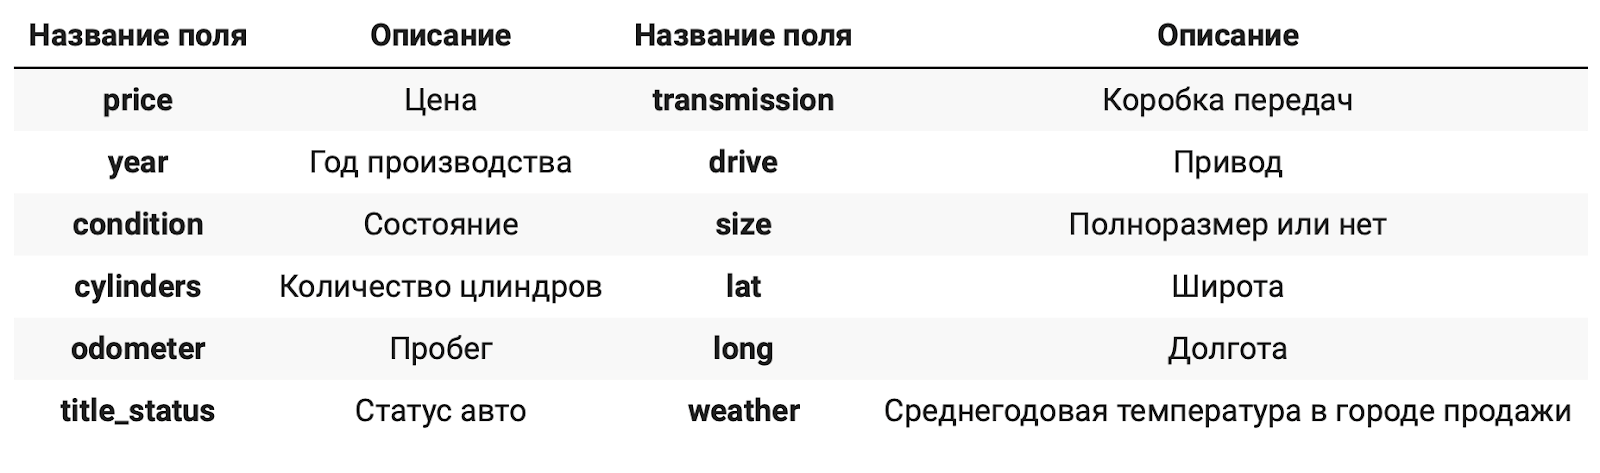

In [77]:
# читаем исходный датасет
data = pd.read_excel('data_ford_price.xlsx')
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


ОБРАБОТКА ПРОПУСКОВ. У нас есть пропуски в признаках: drive, size и weather. Для заполнения у нас не хватает данных, поэтому удалим их.

In [79]:
# обработаем пропуски - просто удалим их
data.dropna(inplace = True)
#data.info()

В нашем датасете 8 числовых признаков и 4 строковые, посмотрим что они из себя представляют.

КОДИРОВАНИЕ ДАННЫХ

In [80]:
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']
 
for column in columns_to_change:
 print('Число уникальных значений признака {}: '.format(column), data[column].nunique())

Число уникальных значений признака cylinders:  6
Число уникальных значений признака title_status:  5
Число уникальных значений признака transmission:  3
Число уникальных значений признака drive:  3
Число уникальных значений признака size:  4


Наши строковые признаки - категориальные, номинальные, менее 15 значений. Для них подойдет однократное кодирование OneHotEncoder. Так же у нас есть признак cylinders - это числовой номинальный признак имеет 6 уникальных значений , его тоже  нужно закодировать.

In [81]:
one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(data[columns_to_change]).toarray()
 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
print(column_names)

['cylinders_3' 'cylinders_4' 'cylinders_5' 'cylinders_6' 'cylinders_8'
 'cylinders_10' 'title_status_clean' 'title_status_lien'
 'title_status_missing' 'title_status_rebuilt' 'title_status_salvage'
 'transmission_automatic' 'transmission_manual' 'transmission_other'
 'drive_4wd' 'drive_fwd' 'drive_rwd' 'size_compact' 'size_full-size'
 'size_mid-size' 'size_sub-compact']


In [82]:
# создаем DataFrame из закодированных данных и задаем имена колонок, объединяем с основным датасетом, удаляем исходные колонки для кодирования
data_onehot = pd.DataFrame(data_onehot, index=data.index, columns=column_names)
data = pd.concat([data, data_onehot], axis=1)
data = data.drop(columns=columns_to_change)
#data.info()

МАСШТАБИРОВАНИЕ И ТРАНСФОРМАЦИЯ РАСПРЕДЕЛЕНИЙ ПРИЗНАКОВ

В зависимости от задачи и типа данных, масштабирование и трансформация распределения признаков могут быть полезными инструментами для предобработки данных.

Масштабирование может быть полезно, если значения признаков имеют разный масштаб и это может повлиять на работу алгоритмов машинного обучения. Например, если один признак имеет значения в диапазоне от 0 до 1, а другой - от 0 до 1000, то алгоритм может считать, что второй признак важнее, хотя это может быть не так. Масштабирование позволяет привести значения признаков к одному масштабу, что может улучшить работу алгоритмов.

Трансформация распределения признаков может быть полезна, если распределение значений признака не является нормальным или имеет выбросы. Трансформация может помочь сделать распределение более нормальным и убрать выбросы, что может улучшить работу алгоритмов машинного обучения.

Таким образом, выбор между масштабированием и трансформацией распределения признаков зависит от конкретной задачи и данных.

In [83]:
# посмотрим на распределение числовых признаков
data_cut = data[['price', 'year', 'odometer', 'lat', 'long', 'weather']]
data_cut.describe()

,price,year,odometer,lat,long,weather
count,5202.000000,5202.000000,5.202000e+03,5202.000000,5202.000000,5202.000000
mean,15388.826797,2008.198577,1.173255e+05,39.288263,-90.345207,52.149942
std,10820.253885,6.676873,8.443138e+04,5.345894,12.914642,7.727490
min,1.000000,1965.000000,0.000000e+00,25.739200,-151.055832,29.000000
25%,6800.000000,2005.000000,7.121100e+04,35.661076,-94.366510,45.000000
50%,13880.000000,2010.000000,1.151170e+05,40.078600,-88.063080,51.000000
75%,21995.000000,2013.000000,1.530450e+05,43.204762,-82.378235,59.000000
max,74374.000000,2018.000000,2.490000e+06,64.837800,-68.412100,71.000000


condition — это порядковый признак, который уже представлен в числовом формате, его кодировать не нужно. Оставим как есть.

In [84]:
# в обучающих материалах при построении карты по координатам у нас были выбросв и некоторые данные находились в море. Посмотрим на распределение точек после удаления данных с пропусками
# выбросы пропали
fig = px.scatter_geo(data,lat='lat',lon='long', hover_name="price")
fig.update_layout(title='Интерактивная карта цены автомобиля в зависимости от локации',
    title_x=0.5,
    width=1000,
    height=800)
fig.show()

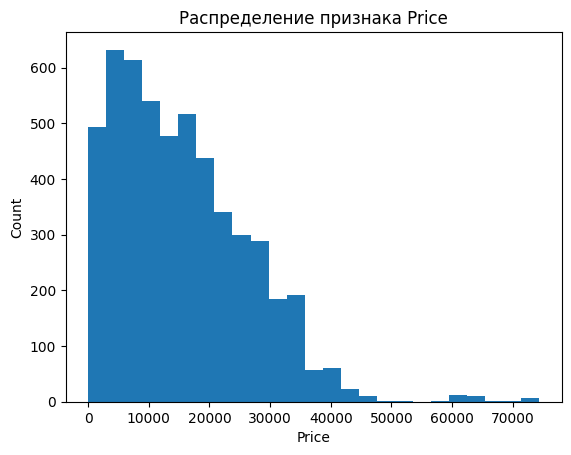

In [85]:
# посмотрим на распределение целевого признака price. 

plt.hist(data['price'], bins=25)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Распределение признака Price')
plt.show()

Если целевой признак содержит выбросы, то нужно преобразовать его, чтобы он имел более нормальное распределение. Например, преобразованием Йео-Джонсона, которое учитывает при расчётах нулевые и отрицательные значения обрабатываемых переменных. Код преобразования представлен нижею. 
Также можно оставить целевой признак без преобразования и использовать алгоритмы, устойчивые к выбросам, например, Random Forest или Gradient Boosting. Но в задании необходимо обучить модель линейной регрессии и мы в свою очередь не будем делать преобразований, чтобы метрика MAE была понятна без обратного преобразования.  

In [86]:
#data['price'], _ = yeojohnson(data['price'])
 
#plt.hist(data['price'])
#plt.title('Трансформированное распределение признака price')
#plt.show()

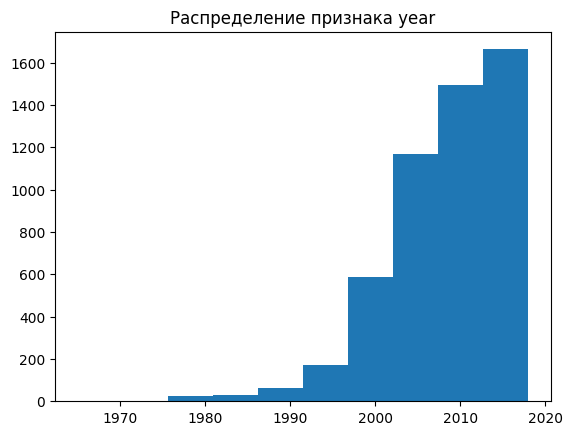

In [87]:
# рассмотрим признак year
plt.hist(data.year)
plt.title('Распределение признака year');

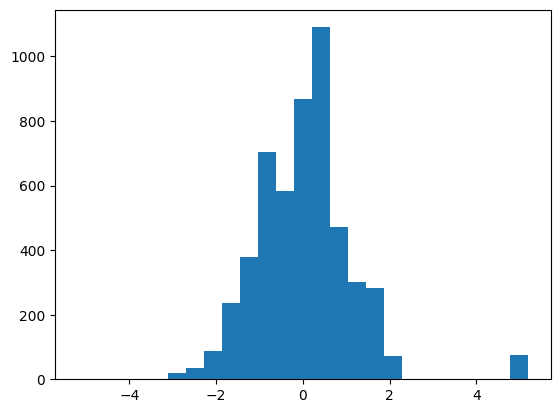

In [88]:
# Преобразование признака с помощью квантильного преобразования
data['year'] = quantile_transform(data[['year']], output_distribution='normal')

# Построение гистограммы преобразованного признака
plt.hist(data['year'], bins=25)
plt.show()

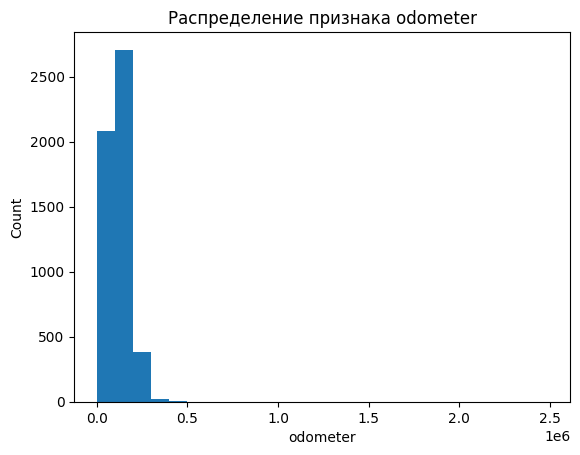

In [89]:
# посмотрим признак odometer
plt.hist(data['odometer'], bins=25)
plt.xlabel('odometer')
plt.ylabel('Count')
plt.title('Распределение признака odometer')
plt.show()

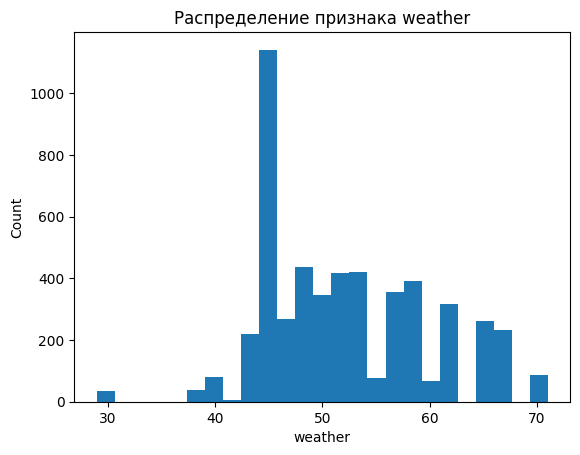

In [90]:
# посмотрим признак weather
plt.hist(data['weather'], bins=25)
plt.xlabel('weather')
plt.ylabel('Count')
plt.title('Распределение признака weather')
plt.show()

Признаки odometer и weather не имеют нормального распределения. масштабируем их с помощью MinMaxScaler

In [91]:
scaler = MinMaxScaler()
data[['odometer', 'weather']] = scaler.fit_transform(data[['odometer', 'weather']])

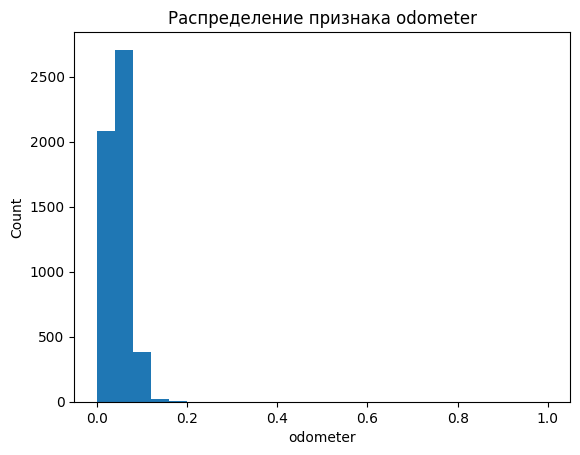

In [92]:
# посмотрим признак odometer после масштабирования
plt.hist(data['odometer'], bins=25)
plt.xlabel('odometer')
plt.ylabel('Count')
plt.title('Распределение признака odometer')
plt.show()

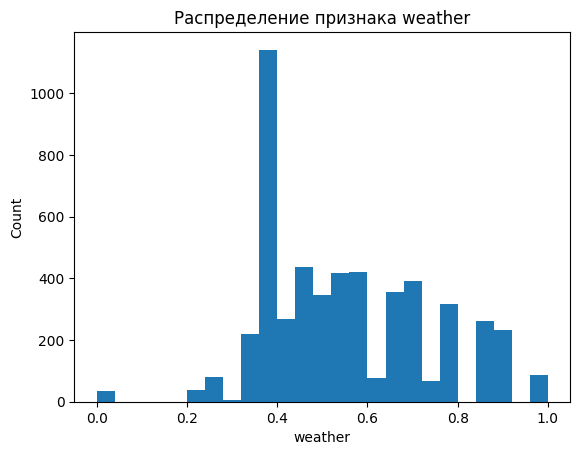

In [93]:
# посмотрим признак weather после масштабирования
plt.hist(data['weather'], bins=25)
plt.xlabel('weather')
plt.ylabel('Count')
plt.title('Распределение признака weather')
plt.show()

ОТБОР ПРИЗНАКОВ

<AxesSubplot: >

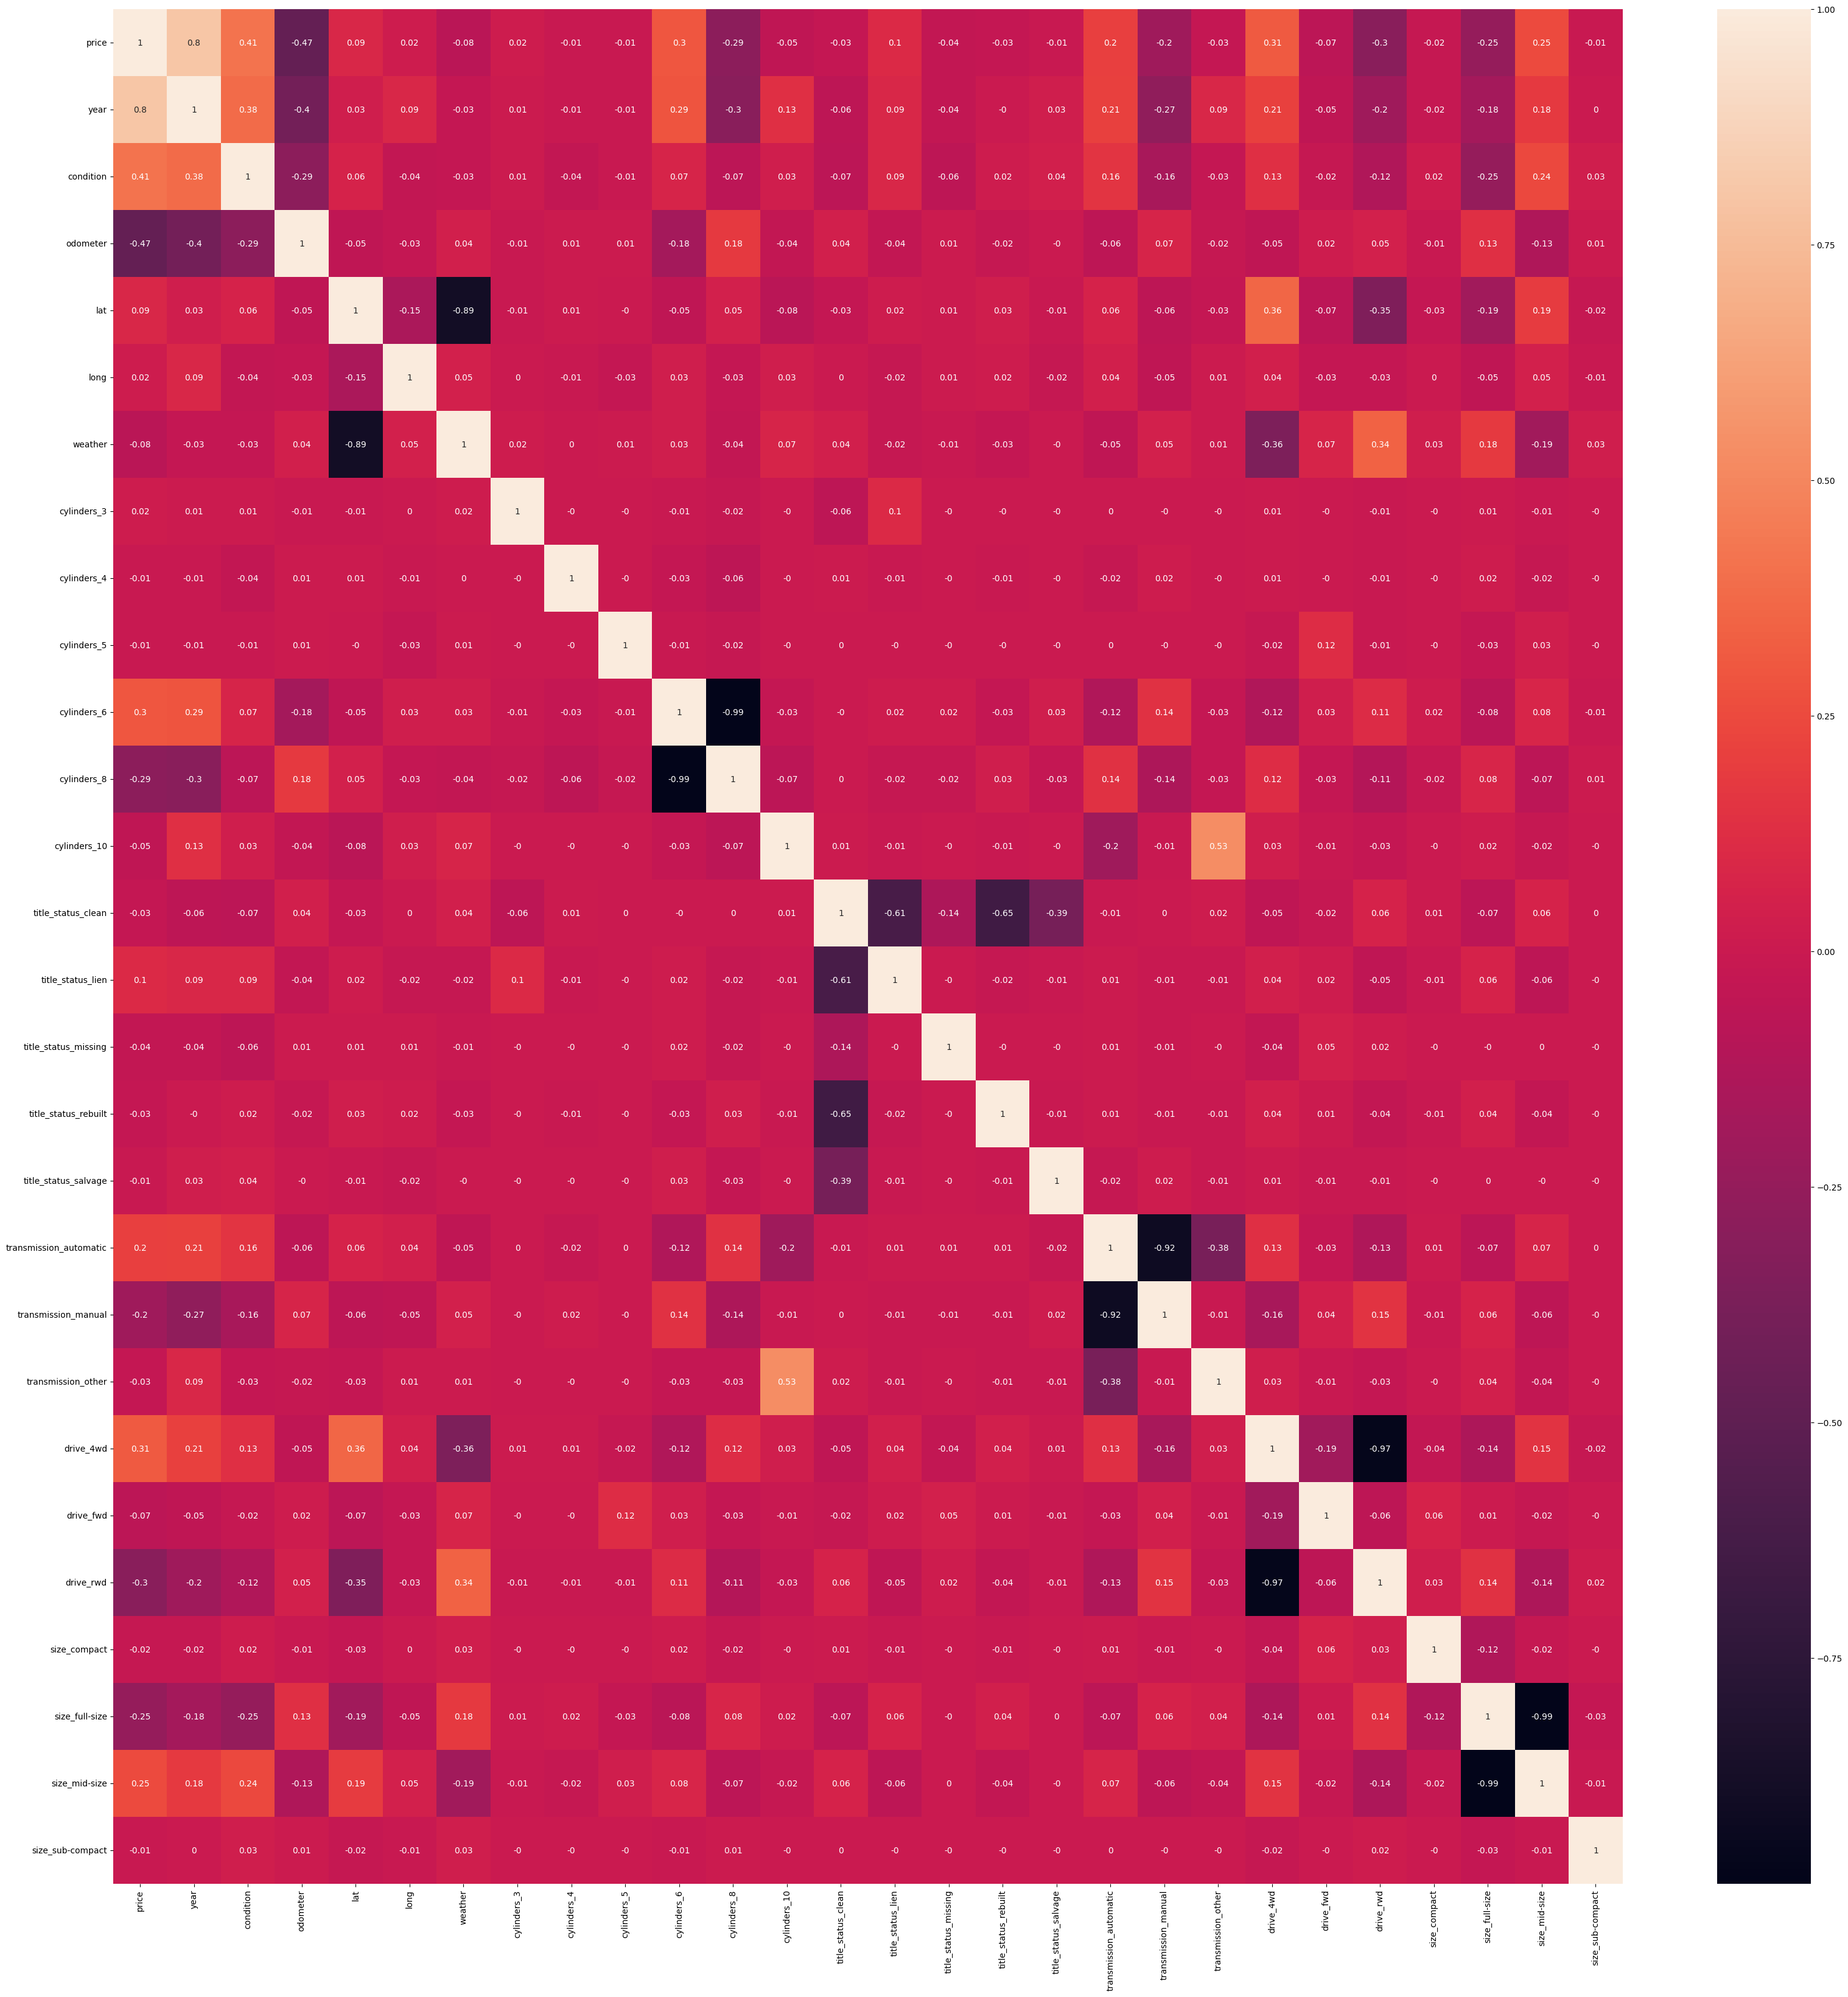

In [94]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(data.corr().round(2), annot=True)

In [95]:
# выделим пары сильно скоррелированных признаков
corr_matrix = data.corr().abs()
high_corr_var_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j]) for i in range(len(corr_matrix.columns)) for j in range(i+1, len(corr_matrix.columns)) if corr_matrix.iloc[i,j] > 0.8]

print(high_corr_var_pairs)

[('lat', 'weather'), ('cylinders_6', 'cylinders_8'), ('transmission_automatic', 'transmission_manual'), ('drive_4wd', 'drive_rwd'), ('size_full-size', 'size_mid-size')]


In [96]:
# удаляем один из скоррелированых признаков в паре 

data = data.drop(['lat', 'cylinders_8', 'transmission_manual', 'drive_rwd', 'drive_rwd'], axis=1)

In [97]:
# выделяем целевой признак
y = data['price']
X = data.drop(columns='price')

# разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [98]:
# модель обученная на всех признаках
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [99]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('R^2:', r2)

MAE: 3955.391230517211
R^2: 0.7247179449562987


In [100]:
# RFE
rfe = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe.fit(X_train, y_train)
rfe_features = X_train.columns[rfe.support_]
rfe_features

Index(['odometer', 'cylinders_10', 'size_sub-compact'], dtype='object')

In [101]:
# SelectKBest
skb = SelectKBest(k=3)
skb.fit(X_train, y_train)
skb_features = X_train.columns[skb.get_support()]
skb_features

Index(['year', 'size_full-size', 'size_mid-size'], dtype='object')

Здесь мы использовали классы `RFE` и `SelectKBest` из библиотеки `sklearn` для выбора трех наиболее важных признаков. В результате получили два списка признаков: `rfe_features` и `skb_features`.
Теперь обучим модель линейной регрессии на первых трех признаках и оценим ее качество на тестовой выборке:

In [102]:
# RFE
rfe_model = LinearRegression().fit(X_train[rfe_features], y_train)
rfe_pred = rfe_model.predict(X_test[rfe_features])
rfe_mae = mean_absolute_error(y_test, rfe_pred)
rfe_r2 = r2_score(y_test, rfe_pred)

In [103]:
# SelectKBest
skb_model = LinearRegression().fit(X_train[skb_features], y_train)
skb_pred = skb_model.predict(X_test[skb_features])
skb_mae = mean_absolute_error(y_test, skb_pred)
skb_r2 = r2_score(y_test, skb_pred)

Здесь мы обучили модели линейной регрессии на первых трех признаках, полученных с помощью методов RFE и SelectKBest, и оценили их качество на тестовой выборке с помощью метрик MAE и R^2.

Наконец, сравним метрики качества моделей и сделаем вывод о том, какой метод отбора признаков показал наилучший результат на тестовой выборке:

In [105]:
print("Все признаки: MAE = {:.2f}, R^2 = {:.2f}".format(mae, r2))
print("RFE: MAE = {:.2f}, R^2 = {:.2f}".format(rfe_mae, rfe_r2))
print("SelectKBest: MAE = {:.2f}, R^2 = {:.2f}".format(skb_mae, skb_r2))

Все признаки: MAE = 3955.39, R^2 = 0.72
RFE: MAE = 7117.82, R^2 = 0.30
SelectKBest: MAE = 4601.67, R^2 = 0.62


#### **Вывод:**

MAE (Mean Absolute Error) - это метрика, которая измеряет среднее абсолютное отклонение (разницу) между прогнозируемыми и фактическими значениями. 

R2 (R-квадрат) - это метрика, которая измеряет, насколько хорошо модель соответствует данным. Чем ближе R2 score к 1, тем лучше модель соответствует данным.

Таким образом, у нас есть метрика MAE, рассчитанная для 3 моделей линейной регрессии:
* модель линейной регрессии для всех числовых признаков;

* модель линейной регрессии для признаков `['odometer', 'cylinders_10', 'size_sub-compact']`, полученных методом рекурсивного исключения признаков (RFE);

* модель линейной регрессии для признаков `['year', 'size_full-size', 'size_mid-size']`, полученных методом выбор k лучших признаков (SelectKBest).

Интересуют модели *вторая* и *третья*:

* RFE  MAE = 7117.82, R^2 = 0.30

* SelectKBest MAE = 4601.67, R^2 = 0.62

Можно сделать вывод, что модель, обученная с использованием метода SelectKBest, показала лучшие результаты по метрикам MAE и R^2, чем модель, обученная с использованием метода RFE. Это может быть связано с тем, что метод SelectKBest выбирает наиболее значимые признаки для моделирования, в то время как метод RFE может удалять признаки, которые могут быть полезны для модели. Однако, для более точного вывода необходимо провести более детальный анализ данных и моделей.

Если сравнивать результаты *третьей* и *первой* моделей, то, безусловно, в первой модели количество числовых признаков превалирует и вносит дополнительную, в данном случае значительную, детализацию модели, построенную на всех числовых признаках, и, как следствие, выигрыш модели на всех числовых признаках несёт положительный отрыв.